# Data cleaning
During our workshops we are going to use a public dataset of tweets, which have been already labelled with sentiment.

In [1]:
import pandas as pd


# Load the original dataset and display some of the rows
raw_tweets = pd.read_csv("datasets/twitter-airlines-sentiment.csv")
raw_tweets.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

As we are not going to include non-textual information in our futher processing, we can limit the dataset in order to have just two columns of the original file: sentiment and the content of each tweet. With pandas, it may be done quite easily.

In [2]:
# Retrieve only two columns which are going to be used later
# and additionally rename them
tweets = raw_tweets[["airline_sentiment", "text"]]
tweets.columns = ("sentiment", "text", )
tweets.head()

sentiment                                               text
0   neutral                @VirginAmerica What @dhepburn said.
1  positive  @VirginAmerica plus you've added commercials t...
2   neutral  @VirginAmerica I didn't today... Must mean I n...
3  negative  @VirginAmerica it's really aggressive to blast...
4  negative  @VirginAmerica and it's a really big bad thing...

In order to have an intuition about our dataset, let's count how many positive, neutral and negative messages we have.

In [3]:
tweets.groupby("sentiment")\
      .size()\
      .reset_index(name="count")

sentiment  count
0  negative   9178
1   neutral   3099
2  positive   2363

As we see, a majority of tweets in the dataset is negative. A model returning the labels randomly, should have an accuracy of 33,33%. On the other hand, a classifier which always returns "negative" should achieve an accuracy of 62,69%. And that's the lower limit for the model we are going to create.

## Data quality
For the purposes of Machine Learning we need to make sure the dataset is of a high quality. The first thing to check. when it comes to textual data, is if all the rows are not empty, or if their length is higher than just a few characters.

In [ ]:
tweets[tweets["text"].str.len() < 10]

Our dataset doesn't contain any empty texts. What's more, there are no texts with the length lower than 10.

There are several other things we may find useful to understand the dataset better. Let's consider the distribution of tweets length:

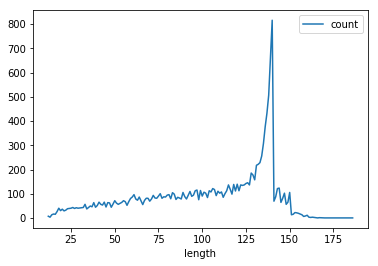

In [29]:
%matplotlib inline

from matplotlib import pyplot 


def display_length_plot(tweets_df):
    """
    Displays a plot of tweets' lengths for given DataFrame.
    :param tweets_df: DataFrame
    """
    lengths = tweets_df["text"].str.len()\
                               .reset_index(name="length")\
                               .groupby("length")\
                               .size()\
                               .reset_index(name="count")
    lengths.plot(x="length", y="count", kind="line")
    
display_length_plot(tweets)

We see how it looks like globally, but it might be also interesting to see if there is any difference between classes. The following lines of code display separate histogram for positive, negative and neutral entries:

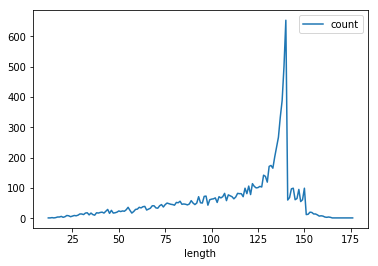

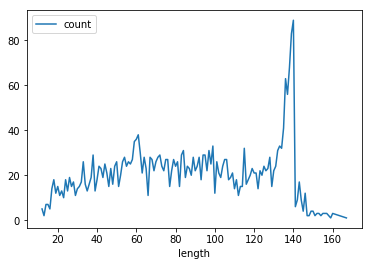

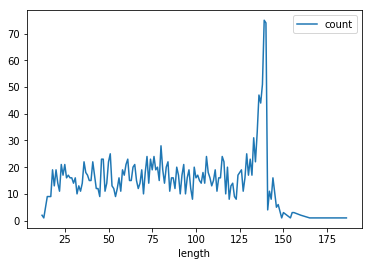

In [24]:
display_length_plot(tweets[tweets["sentiment"] == "negative"])
display_length_plot(tweets[tweets["sentiment"] == "neutral"])
display_length_plot(tweets[tweets["sentiment"] == "positive"])

Let's store the variable for futher usage with a magic function of Jupyter Notebook.

# Data preparation

For the purposes of Machine Learning methods, we usually need to convert the dataset to the mathematical vector, where each dimension defines a different feature. In our case, we need to find a good way of encoding given tweet in such form. There are several possible ways of doing that, but first of all let's dive into the dataset and see if there is anything we can do to improve the quality of the messages we have.

As humans, we don't see any difference between capital and small letters, but for a computer such words would be seen as completely different ones. There are several other corrections we probably need to apply, as our datset is written by some random people, who often don't care about grammatical correctness, etc. Let's then analyze the dataset we have and see if we can correct some common issues.

As a first step, we are going to analyze the frequencies of all the words.

In [2]:
# Divide each tweet by its words
tweet_words = tweets["text"].str.split()
tweet_words.head()

0             [@VirginAmerica, What, @dhepburn, said.]
1    [@VirginAmerica, plus, you've, added, commerci...
2    [@VirginAmerica, I, didn't, today..., Must, me...
3    [@VirginAmerica, it's, really, aggressive, to,...
4    [@VirginAmerica, and, it's, a, really, big, ba...
Name: text, dtype: object

For each tweet we received a list of its words, but to analyze global frequencies, we need to combine all the lists together.

In [3]:
import pandas as pd

# Chain all the lists into one Series object
words = tweet_words.apply(pd.Series)\
                   .stack()\
                   .reset_index(drop=True)\
                   .to_frame(name="word")
words.head()

word
0  @VirginAmerica
1            What
2       @dhepburn
3           said.
4  @VirginAmerica

In [4]:
words.groupby("word")\
     .size()\
     .reset_index(name="count")

word  count
0                                             !     48
1                                            !!     22
2                                           !!!     11
3                                          !!!!      3
4                                         !!!!!      3
5                                        !!!!!!      1
6                                            !=      1
7                                            !?      2
8                                          !?!?      1
9                                    !Cancelled      1
10                                          !we      1
11                                            "      6
12                                        "#flt      1
13                                           ".      1
14                                    "...still      1
15                                      "...you      1
16                                          "18      1
17                                    "@DJQ_KC:      1
18                                   "@JetBlue:      5
19                                    "@united:      1
20                                          "A"      2
21                                      "Able"?      1
22                                      "Active      1
23                                       "Agent      1
24                                     "Airport      5
25                                    "Airserv"      1
26                                    "Anthony"      1
27                                        "Best      1
28                                      "Better      1
29                                        "Blue      1
...                                         ...    ...
30075                                        üò©üò≠      1
30076                                       üò©üò≠üíî      1
30077                                       üò´üò´üò´      1
30078                                         üò¨      1
30079                                         üò≠      7
30080                                      üò≠üòÅüòÜüòµ      1
30081                                        üò≠üò≠      3
30082                                 üò≠üò≠üíîüíîüíîüíîüíîüíîüíî      1
30083                                       üò≠üò≠üò≠      1
30084                                      üò≠üò≠üò≠üò≠      1
30085                                        üò≠üôè      1
30086                                         üòÆ      1
30087                                     üò±‚ù§Ô∏èim      1
30088                                         üò≥      3
30089                                      üò≥...      1
30090                                         üò∑      1
30091                                        üò∑üò±      1
30092                                         üôÖ      1
30093                                       üôÖüôÖüôÖ      1
30094                                         üôà      1
30095                                         üôâ      1
30096                                         üôå      1
30097                                       üôå‚úàÔ∏è      1
30098                                        üôåüòè      1
30099                                        üôåüôå      1
30100                                         üôè      7
30101                                 üôèüôèüôèüò¢üò¢üò¢üôèüôèüôè      1
30102  üôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüò¢üò¢üò¢üò¢üò¢üò¢üò¢üò¢üôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôèüôè      1
30103                                         üö´      1
30104                                      üö∂üö∂üö∂üö∂      1

[30105 rows x 2 columns]

Our dataset is built from 30105 unique words. As we may see, there are some common issues:
* lowercase and uppercase written words are different to our system
* as our dataset is taken from Twitter, there are a lot of hashtags and mentions of other users
* duplicated emojis form separate words - üò≠üò≠üò≠ and üò≠üò≠üò≠üò≠ are completely different, even though from human perspective they're almost the same
* some words are embraced with quotation marks
* there are a lot of duplicated exclamation, question marks, etc.
* spaces are not put correctly - for instance, somebody didn't use space after a dot

We need to preprocess the dataset to get rid of all these issues, which may be confusing in our further processing.

In [5]:
import re

# https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1
EMOJI_REGEX = re.compile("([\U00010000-\U0010ffff])", re.UNICODE)
DUPLICATED_LETTER_REGEX = re.compile(r"([^a-z0-9])\1+", re.UNICODE | re.I)
PUNCTUATION_MARKS_REGEX = re.compile(r"([,\.\!\?\[\]\(\)])", re.UNICODE)


def preprocess_text(raw_text):
    # Convert all the letters to lowercase
    text = raw_text.lower()
    # Remove hashtag symbol and "at" for user mentions
    text = text.replace("#", "")
    text = text.replace("@", "")
    # Divide the emojis written in a row with spaces
    text = EMOJI_REGEX.sub("\\1 ", text)
    # Remove quotation marks
    text = text.replace("\"", "")
    text = text.replace("'", "")
    # Get rid of the misused spaces by
    text = PUNCTUATION_MARKS_REGEX.sub(" \\1 ", text)
    # Divide duplicated characters, so after text split they'll be treated
    # as if they were a single character used a couple of times
    text = DUPLICATED_LETTER_REGEX.sub("\\1", text)
    # Return preprocessed value
    return text

We have the logic for a simple preprocessing prepared, so let's see how it affects the dictionary.

In [6]:
# Divide each tweet by its words, but perform the preprocessing first
tweet_words = tweets["text"].apply(preprocess_text).str.split()
# Chain all the lists into one Series object
words = tweet_words.apply(pd.Series)\
                   .stack()\
                   .reset_index(drop=True)\
                   .to_frame(name="word")
words_occurences = words.groupby("word").size().reset_index(name="count")
words_occurences

word  count
0                        !   5312
1                        $     47
2                   $&amp;      1
3                       $+      1
4                       $0      3
5                       $1      2
6                      $10      2
7                     $100     16
8                    $1000      6
9               $1000cost-      1
10                   $1038      1
11                   $1051      1
12     $10voucherwhatajoke      1
13                   $1130      1
14                     $12      1
15                    $120      1
16                   $1200      2
17                    $125      3
18                    $130      2
19                   $1300      2
20                     $15      3
21                    $150     11
22                    $154      1
23                    $157      1
24                    $159      1
25                   $1600      1
26                    $165      2
27                     $17      2
28                    $170      1
29                    $174      1
...                    ...    ...
17131                    üòò      4
17132                    üòú      7
17133                    üòû      6
17134                    üò†      4
17135                    üò°     29
17136                    üò¢     32
17137                    üò£      1
17138                    üò§      8
17139                    üò•      5
17140                    üò¶      1
17141                    üò©     18
17142                    üò™      1
17143                    üò´      4
17144                    üò¨      2
17145                    üò≠     40
17146                    üòÆ      1
17147                    üò±      2
17148                    üò≤      1
17149                    üò≥      4
17150                    üòµ      1
17151                    üò∑      2
17152                    üòª      2
17153                    üôÖ      4
17154                    üôà      1
17155                    üôâ      1
17156                    üôå      6
17157                    üôè    119
17158                    üö™      1
17159                    üö´      1
17160                    üö∂      4

[17161 rows x 2 columns]

We've succesfully reduced the dimensionality of our dictionary to 17161 words. The next step would be to analyze the words which have only one occurrence, in order to recoginze some more issues like spelling, etc.

In [7]:
words_occurences[words_occurences["count"] == 1]

word  count
2                   $&amp;      1
3                       $+      1
9               $1000cost-      1
10                   $1038      1
11                   $1051      1
12     $10voucherwhatajoke      1
13                   $1130      1
14                     $12      1
15                    $120      1
22                    $154      1
23                    $157      1
24                    $159      1
25                   $1600      1
28                    $170      1
29                    $174      1
30                    $179      1
34                    $192      1
36                $1per/hr      1
37                      $2      1
40               $200/trip      1
41                    $209      1
42                   $2275      1
43                     $24      1
45                $25-$100      1
46                 $25/bag      1
50                    $285      1
51                    $297      1
52                    $299      1
56                  $300rt      1
57                    $304      1
...                    ...    ...
17059               ‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è      1
17060      ‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚Äújetblue:      1
17061                    ‚§¥      1
17062                    ‚§µ      1
17063                 ‚§µfor      1
17064                   ‚≠êÔ∏è      1
17065           ‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è      1
17066                    üÜñ      1
17081                    üé≤      1
17082                    üéµ      1
17083                    üê≥      1
17084                    üê¥      1
17086                    üëâ      1
17088                    üëã      1
17094                    üë∏      1
17095                    üë∫      1
17101                    üíò      1
17106                    üí™      1
17115                    üòÖ      1
17117                    üòà      1
17137                    üò£      1
17140                    üò¶      1
17142                    üò™      1
17146                    üòÆ      1
17148                    üò≤      1
17150                    üòµ      1
17154                    üôà      1
17155                    üôâ      1
17158                    üö™      1
17159                    üö´      1

[10333 rows x 2 columns]

It seems we have a lot of similar entries, words starting with dolar sign, for instance. Let's group the words by their first letter and see if there is something we can correct in the data.

In [8]:
words_occurences[words_occurences["count"] == 1].groupby(lambda idx: words_occurences["word"][idx][0])["word"]\
                                                .apply(list)\
                                                .to_frame()

word
$   [$&amp;, $+, $1000cost-, $1038, $1051, $10vouc...
%                                                 [%]
&   [&amp;$250, &amp;&amp;, &amp;feel, &amp;only, ...
*   [*alliance, *any, *anything*, *bops, *cough*, ...
+   [+$400/ticket, +-10pm, +1-703-464-0200, +20min...
-   [-&gt;southwestair, -0, -17, -17mph, -1st, -30...
/                          [/dying, /i, /pbi, /ua795]
0   [0%, 0/3, 000ft, 000lbs, 0011, 0162389030167, ...
1   [1&amp;2, 1+hour, 1-15, 1-2888155964, 1-3, 1-3...
2   [2-, 2-1/2, 2-4, 2/10, 2/11/15, 2/13, 2/14/15,...
3   [3-1/2, 3-10, 3-5, 3-6, 3-8, 3-a, 3-yr-old, 3/...
4   [4-10, 4-4, 4-5, 4-50, 4-minute, 4/1/15-4/17/1...
5   [5%, 5-, 5-12, 5-19, 5-8pm, 5-minute, 5/17, 5/...
6   [6&amp;8, 6-year-old, 6/15, 6/25, 6/28, 60+, 6...
7   [7-day, 7-hour, 70+, 702, 704, 70f, 70min, 70o...
8   [8+, 8-10, 8/10, 80-90%, 800-335-2247, 800-555...
9   [9+hours, 9-hour, 9/11, 90%, 901, 904am, 906, ...
:                     [:-d, :15, :arrived, :take, :x]
;                                            [;:, ;p]
=                              [=/, =unamerican, =we]
^   [^, ^_^, ^ah, ^cp‚Äùdone, ^ey, ^ha, ^jj, ^jj‚Äù, ^...
_   [_austrian, _defcon_, _emmaclifford, _exact_, ...
a   [a&amp;c, a-&gt;b, a-list-ey, a-ok, a18, a20, ...
b   [b13, b18, b3, b36a, b44, b46, b737-800w, b737...
c   [c-130, c-team, c/s, c12, c14, c16, c17, c22, ...
d   [d/fw, d1mqf5, d4, d6, d9, d_goodspeed, da, da...
e   [e-book, e-certificate, e-rewards, e-ticket, e...
f   [f$%ing, f&amp;$king, f&amp;&amp;%$cking, f*%e...
g   [g6455c, g8, g8cvwj, gabriela, gagent, gah, ga...
h   [h8, habitrails, habitually, hacked, hahah, ha...
..                                                ...
‚úî                                                [‚úîÔ∏è]
‚ùÑ                            [‚ùÑÔ∏è, ‚ùÑÔ∏è‚õÑÔ∏è, ‚ùÑÔ∏è‚ùÑÔ∏è, ‚ùÑÔ∏è‚ùÑÔ∏è‚ùÑÔ∏è]
‚ùå                                                 [‚ùå]
‚ù§   [‚ù§Ô∏èfrom, ‚ù§Ô∏èim, ‚ù§Ô∏èny, ‚ù§Ô∏èyou, ‚ù§Ô∏è‚ú®, ‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è, ‚ù§Ô∏è‚ù§Ô∏è‚ù§...
‚§¥                                                 [‚§¥]
‚§µ                                           [‚§µ, ‚§µfor]
‚≠ê                                    [‚≠êÔ∏è, ‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è]
üÜñ                                                 [üÜñ]
üé≤                                                 [üé≤]
üéµ                                                 [üéµ]
üê≥                                                 [üê≥]
üê¥                                                 [üê¥]
üëâ                                                 [üëâ]
üëã                                                 [üëã]
üë∏                                                 [üë∏]
üë∫                                                 [üë∫]
üíò                                                 [üíò]
üí™                                                 [üí™]
üòÖ                                                 [üòÖ]
üòà                                                 [üòà]
üò£                                                 [üò£]
üò¶                                                 [üò¶]
üò™                                                 [üò™]
üòÆ                                                 [üòÆ]
üò≤                                                 [üò≤]
üòµ                                                 [üòµ]
üôà                                                 [üôà]
üôâ                                                 [üôâ]
üö™                                                 [üö™]
üö´                                                 [üö´]

[101 rows x 1 columns]

From the human point of view, use of some diactric marks is an useful piece of information, when it comes to the meaning of a particular sentence, so we are going to keep them.

### Exercise 1

As we see, there are some more issues with the data, for instance:
- html entities are encoded (< as &amp;lt;, > as &amp;gt;, etc.)
- leading special characters, like ‚ù§Ô∏èfrom, :arrived, =we, /dying, \*any

The goal of this exercise is to review the dictionary once again to find some more issues, and to include the corrections for all the found problems in our **preprocess_text** function. Please modify the code below with your changes before going further.

In [9]:
import re

# https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1
EMOJI_REGEX = re.compile("([\U00010000-\U0010ffff])", re.UNICODE)
DUPLICATED_LETTER_REGEX = re.compile(r"([^a-z0-9])\1+", re.UNICODE | re.I)
PUNCTUATION_MARKS_REGEX = re.compile(r"([,\.\!\?\[\]\(\)])", re.UNICODE)


def preprocess_text(raw_text):
    # Convert all the letters to lowercase
    text = raw_text.lower()
    # Remove hashtag symbol and "at" for user mentions
    text = text.replace("#", "")
    text = text.replace("@", "")
    # Divide the emojis written in a row with spaces
    text = EMOJI_REGEX.sub("\\1 ", text)
    # Remove quotation marks
    text = text.replace("\"", "")
    text = text.replace("'", "")
    # Get rid of the misused spaces by
    text = PUNCTUATION_MARKS_REGEX.sub(" \\1 ", text)
    # Divide duplicated characters, so after text split they'll be treated
    # as if they were a single character used a couple of times
    text = DUPLICATED_LETTER_REGEX.sub("\\1", text)
    # Return preprocessed value
    return text

In [ ]:
# Divide each tweet by its words, but perform the preprocessing first
tweet_words = tweets["text"].apply(preprocess_text).str.split()
# Chain all the lists into one Series object
words = tweet_words.apply(pd.Series)\
                   .stack()\
                   .reset_index(drop=True)\
                   .to_frame(name="word")
words_occurences = words.groupby("word")\
                        .size()\
                        .reset_index(name="count")
words_occurences.sort_values("count", ascending=False)

In [ ]:
words_occurences[words_occurences["count"] == 1].groupby(lambda idx: words_occurences["word"][idx][0])["word"]\
                                                .apply(list)\
                                                .to_frame()

## Sentiment analysis methods

There is no ML method which solves specifically the problem of sentiment analysis, so it is important to test some different algorithms and choose the best one. In our tests we are going to use scikit-learn library, which is commonly used, especially for implementing POCs.

The quality of the ML model has to be measured somehow in order to compare their efficiency for given problem. In our case we are going to use quite a simple metric, called accuracy. 

$$accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$$

We have three different labels for our texts: positive, negative and neutral. To avoid dealing with texts, we are going to convert them to 1, -1 and 0, respectively.

Let's start with defining a base pipeline for our dataset. We're going to use some functions declared in previous parts of the training.

In [2]:
import pandas as pd

SENTIMENT_TO_LABEL_MAPPING = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}

# Load the dataset
raw_tweets = pd.read_csv("data/twitter-airlines-sentiment.csv")

# Preprocess the data with the function declared previously
tweets = raw_tweets[["airline_sentiment", "text"]]
tweets.columns = ("sentiment", "text", )
tweets["text"] = tweets["text"].map(preprocess_text)
tweets["sentiment"] = tweets["sentiment"].map(lambda x: SENTIMENT_TO_LABEL_MAPPING[x])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [3]:
from sklearn.model_selection import train_test_split


# Divide the dataset into train and test fraction
train_messages, test_messages, train_targets, test_targets = train_test_split(tweets["text"], 
                                                                              tweets["sentiment"],
                                                                              test_size=0.2)

In [4]:
import itertools

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Declare vectorizers to be used
VECTORIZERS = (
    CountVectorizer(),
    TfidfVectorizer(),
)

# Declare classifiers to be used
CLASSIFIERS = (
    LogisticRegression(C=10e-5, solver="liblinear", max_iter=10000),
    KNeighborsClassifier(3),
    KNeighborsClassifier(9),
    KNeighborsClassifier(27),
    SVC(kernel="rbf", C=0.025, probability=True),
    LinearSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=2018),
    GaussianNB(),
)

for vectorizer, classifier in itertools.product(VECTORIZERS, CLASSIFIERS):
    # Vectorize preprocessed sentences
    train_features = vectorizer.fit_transform(train_messages)

    # Train the model
    %time fit = classifier.fit(train_features.toarray(), train_targets)

    # Check the accuracy of the model on test data and display it
    test_features = vectorizer.transform(test_messages)
    %time test_predictions = fit.predict(test_features.toarray())
    accuracy = accuracy_score(test_predictions, test_targets)
    print("Vectorizer: {}\nClassifier: {}\nAccuracy score:{}\n".format(vectorizer,
                                                                       classifier, 
                                                                       accuracy))

CPU times: user 962 ms, sys: 1.42 s, total: 2.39 s
Wall time: 1.36 s
CPU times: user 186 ms, sys: 156 ms, total: 342 ms
Wall time: 341 ms
Vectorizer: CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Classifier: LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy score:0.6232923497267759

CPU times: user 13.7 s, sys: 546 ms, total: 14.3 s
Wall time: 14.3 s
CPU times: user 13min 13s, sys: 190 ms, total: 13min 13s
Wall time: 13min 13s
Vectorizer:

CPU times: user 9.41 s, sys: 380 ms, total: 9.79 s
Wall time: 9.78 s
CPU times: user 12min 12s, sys: 88 ms, total: 12min 12s
Wall time: 12min 12s
Vectorizer: TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
Accuracy score:0.7315573770491803

CPU times: user 9.33 s, sys: 424 ms, total: 9.75 s
Wall time: 9.73 s
CPU times: user 12min 13s, sys: 88 ms, total: 12min 13s
Wall time: 12min 13s
Vectorizer: TfidfVectorizer(analyzer='wo

## Random Forest for sentiment analysis

In the previous chapter we saw one of the most promising models was based on Random Forest. It combines quite a good accuracy with a performance. It is really important if we'd like to move our model to production, so the best architecture, in terms of its precision, is not always a possible choice. 

We are going to begin with a simple description of the Random Forest, to understand how it works under the hood. In simple words, Random Forest is a collection of ensembled Decision Trees which vote in order to form a single decision of belonging to a particular class. Each Decision Tree uses a randomly selected subset of features in order to perform its own decision.

### Tuning the model parameters

Let's play a little bit with the hyperparameters of the Random Forest Classifier, to optimize its accuracy. First of all, let's list some of the possible parameters and their values: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

From our perspective the following parameters look like the ones we should test out:

- **n_estimators** - number of decision trees used to make a forest, by default set to 10
- **criterion** - quality function for measuring a split, can be set to "gini" (default) or "entropy"
- **max_features** - a maximum number of features to consider (int - exact number, float - percentage, "auto", "sqrt", "log2", None)

In [1]:
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


N_ESTIMATORS = (5, 10, 25, 50, 100)
CRITERION = ("gini", "entropy")
MAX_FEATURES = ("auto", "log2", None)

# Divide the dataset into train and test fraction
train_messages, test_messages, train_targets, test_targets = train_test_split(tweets["text"], 
                                                                              tweets["sentiment"],
                                                                              test_size=0.2)


vectorizer = TfidfVectorizer()
for n_estimators, criterion, max_features in itertools.product(N_ESTIMATORS,
                                                               CRITERION,
                                                               MAX_FEATURES):
    # Define the classifier instance
    classifier = RandomForestClassifier(random_state=2018, 
                                        n_estimators=n_estimators, 
                                        criterion=criterion, 
                                        max_features=max_features)
    # Vectorize preprocessed sentences
    train_features = vectorizer.fit_transform(train_messages)

    # Train the model
    %time fit = classifier.fit(train_features.toarray(), train_targets)

    # Check the accuracy of the model on test data and display it
    test_features = vectorizer.transform(test_messages)
    train_predictions = fit.predict(train_features.toarray())
    train_accuracy = accuracy_score(train_predictions, train_targets)
    test_predictions = fit.predict(test_features.toarray())
    test_accuracy = accuracy_score(test_predictions, test_targets)
    print("Configuration: n_estimators = {}, criterion = {}, max_features = {}\n"
          "Train accuracy score: {}\n"
          "Test accuracy score: {}\n".format(n_estimators, criterion, max_features, 
                                             train_accuracy, test_accuracy))

CPU times: user 5.24 s, sys: 568 ms, total: 5.81 s
Wall time: 5.81 s
Configuration: n_estimators = 5, criterion = gini, max_features = auto
Train accuracy score: 0.9608948087431693
Test accuracy score: 0.7209699453551912

CPU times: user 2.56 s, sys: 524 ms, total: 3.08 s
Wall time: 3.09 s
Configuration: n_estimators = 5, criterion = gini, max_features = log2
Train accuracy score: 0.9596994535519126
Test accuracy score: 0.692964480874317

CPU times: user 2min 46s, sys: 509 ms, total: 2min 47s
Wall time: 2min 47s
Configuration: n_estimators = 5, criterion = gini, max_features = None
Train accuracy score: 0.9564549180327869
Test accuracy score: 0.7182377049180327

CPU times: user 5.81 s, sys: 704 ms, total: 6.52 s
Wall time: 6.52 s
Configuration: n_estimators = 5, criterion = entropy, max_features = auto
Train accuracy score: 0.9627732240437158
Test accuracy score: 0.7161885245901639

CPU times: user 2.6 s, sys: 500 ms, total: 3.1 s
Wall time: 3.1 s
Configuration: n_estimators = 5, crite

It turned out the following configuration achieves the best accuracy on our test dataset:

`n_estimators = 100, criterion = gini, max_features = auto`

For that reason we are going to create a simple application that will use these parameters for training. That will be a console application reading the sentences from the user and classifies its sentiment.

### Excercise 2

Please fill the gaps in the source code below, in order to create an application that will:

- create Random Forest based model and train it on a whole dataset used in previous examples, using selected parameters (`n_estimators = 100, criterion = gini, max_features = auto`)
- continiously read the sentences from the standard input and classify them with the created model, until "exit" sentence is passed
- display the probabilities of beloning to each class

Some of the functionalities are already prepared - please complete the source code.

In [ ]:
import itertools
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

SENTIMENT_TO_LABEL_MAPPING = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}

# Load the dataset
raw_tweets = pd.read_csv("datasets/twitter-airlines-sentiment.csv")

# Preprocess the data with the function declared previously
tweets = raw_tweets[["airline_sentiment", "text"]]
tweets.columns = ("sentiment", "text", )
tweets["text"] = tweets["text"].map(preprocess_text)
tweets["sentiment"] = tweets["sentiment"].map(lambda x: SENTIMENT_TO_LABEL_MAPPING[x])

# Vectorize the dataset
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(tweets["text"])

# Create the model an train it
model = RandomForestClassifier(n_estimators=100, criterion="gini", max_features="auto", random_state=2018)
model.fit(features, tweets["sentiment"])

# Continuously read the sentences from the standard input
# and classify them with the created model
while True:
    sentence = input("Sentence ('exit' to close): ")
    if sentence.lower() == "exit":
        break
    # Classify the message and display the probabilities
    sentence_features = vectorizer.transform((sentence, ))
    probabilities = model.predict_proba(sentence_features)
    print("Sentence: {}\nProbabilities: {}".format(sentence,
                                                   dict(zip(model.classes_, probabilities[0]))))

## Feature importance

One of the biggest advantages of Random Forest classifier is the ability to describe the importance of the used features. It allows to check which variables have the best predictive force and to understand how the model performs the decision. The following code snippet visualizes the feature importance for our created model:

In [ ]:
%matplotlib inline

feature_importances = pd.DataFrame(model.feature_importances_, 
                                   index=vectorizer.get_feature_names(),
                                   columns=("importance", ))
feature_importances = feature_importances.sort_values("importance", 
                                                      ascending=False)
feature_importances.head(n=100)

# Available sentiment analysis libraries

As sentiment analysis is a common issue, many people try to prepare ML-like architectures to address it. Most of these solutions are tried to be generic, so should be applicable in any domain, however that's not always the case.

The motivation behind this training is that Codete wanted to use sentiment analysis for one of the showcases we show at different conferences from time to time - it performs a realtime sentiment monitoring of tweets for given phrase and visualizing a global perception of that topic. Surpisingly, some of the best known libraries struggle with such short messages, which are typically incorrect in terms of grammar and linguistic correctness in general. Tweets have a tendency to contain a lot of phrases which don't come from the real language, like acronyms, hashtags, etc. There are also several other issues which are different the ones we have in the official English language. 

We believe, having a problem to be solved with Machine Learning, should never start with desiging our own model, but with a research if anyone else had a similar problem, and trying to apply their work, if possible. That was also a process we initially conducted, but existing ones didn't work well on our dataset. That's a good reason to design our own one.

Nevertheless, if you have to use sentiment analysis in your project, you should keep your eye on the following libraries:

## NLTK

Python NLTK is a common NLP library and it already has a built-in and trained model for the sentiment analysis. Let's look at the example, as it is quite simple to be used out of the box.

In [1]:
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# It is required to download the lexicon before starting
nltk.download("vader_lexicon")

# Create the analyzer and try it out
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("The last game of polish national team was awful")

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.273, 'neu': 0.727, 'pos': 0.0, 'compound': -0.4588}

## TextBlob

This is another Python library which aims to address many different NLP problems. One of them is sentiment analysis. Under the hood TextBlob uses NLTK, but not directly the same algorithm, of course. Here is a short demo:

In [1]:
import nltk

from textblob import TextBlob

# Download the language resource used internally
nltk.download("punkt")

# Perform the analysis on given text
blob = TextBlob("The last game of polish national team was awful")
blob.sentiment

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Sentiment(polarity=-0.4666666666666666, subjectivity=0.48888888888888893)

## Stanford CoreNLP

Stanford Univeristy is one of the biggest research centers focused on NLP problems. CoreNLP is a toolkit of different methods used in this area in order to solve some common problems, also sentiment analysis. The library is written in Java and some papers claim it is state-of-the-art tool when it comes to that issue, so it's definitely worth giving a try.

Due to the fact we're using Jupyter Notebook, it's hard to show a working example here - it has a Java interface which is not as easy to be used within this tool as the previous libraries.